# IMPORTS

In [58]:
import matplotlib as mpl
import matplotlib.tri as tri
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
import copy
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C, WhiteKernel
from scipy.stats import norm
from sklearn.decomposition import PCA

import torch
import pandas as pd
import seaborn as sns
import os
import pickle
import datetime
from collections import Counter
import random
import time
import warnings 
warnings.filterwarnings("ignore")

# DATA

## Load Data 

In [10]:
class Data_Handler():
    def __init__(self, dataset_name, maximization=True):

        # Parameters:
        # dataset_name (string)
        #       name of the dataset to use. Options include ['Crossed barrel', 'Perovskite', 'AgNP', 'P3HT', 'AutoAM']
        # maximization (boolean)
        #       If true then the objective value will be positive (maximization objective problem, use for P3HT/CNT, Crossed barrel, AutoAM)
        #       If false then the objective value will be negative (minimzation objective problem, use for Perovskite, AgNP)

        self.dataset = self.load_data(dataset_name)
        self.normalized_dataset = self.process_data(maximization)


    def load_data(self, dataset_name):

        # Parameters:
        # dataset_name (string)
        #       name of the dataset to use. Options include ['Crossed barrel', 'Perovskite', 'AgNP', 'P3HT', 'AutoAM']
        # Outputs:
        # dataset (pd.DataFrame)
        #       dataset in the form of a pandas dataframe

        raw_dataset = pd.read_csv(dataset_name + '_dataset.csv')
        dataset = copy.deepcopy(raw_dataset) 

        return dataset
    

    def process_data(self, maximization):

        # Parameters:
        # maximization (boolean)
        #       If true then the objective value will be positive (maximization objective problem, use for P3HT/CNT, Crossed barrel, AutoAM)
        #       If false then the objective value will be negative (minimzation objective problem, use for Perovskite, AgNP)
        # Outputs:
        # grouped_dataset (pd.DataFrame)
        #       to perform pool-based active learning, need to group the data by unique input feature x value
        #       for each unique x in design space, only keep the average of all evaluations there as its objective value

        feature_names, objective_name = list(self.dataset.columns)[:-1], list(self.dataset.columns)[-1]

        if maximization is True:
            self.dataset[objective_name] = self.dataset[objective_name].values
        if maximization is False:
            self.dataset[objective_name] = -self.dataset[objective_name].values
    
        processed_dataset = self.dataset.groupby(feature_names)[objective_name].agg(lambda x: x.unique().mean())
        processed_dataset = (processed_dataset.to_frame()).reset_index()

        return processed_dataset
    
    
    def get_top_n_indices(self, top_percentage):

        # Parameters:
        # top_percentage (float)
        #       Denotes the top_percentage of data samples as being one of the top samples in the dataset
        #       Ex. top_percentage = 0.05 will retrieve the indices of the top 5% of data samples
        # Outputs:
        # top_indices (list)
        #       list corresponding to the indices of belonging to data samples in the top_percentage of all samples in the dataset

        objective_name = list(self.dataset.columns)[-1]

        n_top = int(math.ceil(len(self.normalized_dataset) * top_percentage))
        top_indices = list(self.normalized_dataset.sort_values(objective_name).head(n_top).index)

        return top_indices
    

    def X_y_split(self):

        # Outputs:
        # X, y (np.array), (np.array)
        #       X, numpy array containing data from the input features
        #       y, numpy array containing data from the output feature 

        feature_names, objective_name = list(self.dataset.columns)[:-1], list(self.dataset.columns)[-1]

        X = self.normalized_dataset[feature_names].values
        y = np.array(self.normalized_dataset[objective_name].values)

        assert len(self.normalized_dataset) == len(X) == len(y), "X and y have a different amount of rows"
        return X, y

In [13]:
# load a dataset
# dataset names = ['Crossed barrel', 'Perovskite', 'AgNP', 'P3HT', 'AutoAM']
data_handler_object = Data_Handler('P3HT')

dataset = data_handler_object.dataset
processed_dataset = data_handler_object.normalized_dataset

# Printing dataset 
csv_path = "P3HT_dataset.csv"   # update path if needed
df = pd.read_csv(csv_path)
#print("Shape:", df.shape)
#print("Columns:", df.columns.tolist())
#display(df.head())

## Preprocessing of Data - Scaling and Standardize 

In [14]:
# Scaling Data
# So objective to mean 0 and unit variance 
candidate_targets = [c for c in df.columns if any(k in c.lower() for k in ["conduct", "target", "y", "label", "objective"])]
if len(candidate_targets) == 0:
    target_col = df.columns[-1]
else:
    target_col = candidate_targets[0]
print("Using target:", target_col)

X_raw = df.drop(columns=[target_col])
X_cols = list(X_raw.columns)
X_raw = X_raw.values
y_raw = df[target_col].values.reshape(-1,1)

y_scaler = StandardScaler()
#y = y_scaler.fit_transform(y_raw).ravel() 
y = -1.0*y_scaler.fit_transform(y_raw).ravel()

# Scale (standardize) inputs 
X_scaler = StandardScaler()
X = X_scaler.fit_transform(X_raw)

print("Prepared X shape:", X.shape, "n_features:", X.shape[1])

Using target: Conductivity (measured) (S/cm)
Prepared X shape: (233, 5) n_features: 5


# MODEL FUNCTIONS

In [51]:
# Gaussian Process Model with ARD 
def make_gp_ard(n_features, seed=None, noise_level=1e-6):
    # Matérn nu=2.5 (Matérn 5/2), anisotropic length-scales by giving length_scale=np.ones(n_features)
    matern = Matern(length_scale=np.ones(n_features), length_scale_bounds=(1e-5, 1e5), nu=2.5)
    kernel = C(1.0, (1e-3, 1e3)) * matern + WhiteKernel(noise_level=noise_level, noise_level_bounds=(1e-10,1e1))
    gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-8, normalize_y=False, n_restarts_optimizer=5, random_state=seed)
    return gp

# Lower Confidence Bound Aqu. Func. 
def acquisition_lcb(mu, sigma, lam=1.0):
    # LCB_lambda = -lambda * mu + sigma and selects argmax (minimization context)
    return -lam * mu + sigma

# Expected Improvement Aqu. Func.
def acquisition_ei(mu, sigma, y_best, xi=0.01):
    sigma_safe = np.maximum(sigma, 1e-9)
    z = (y_best - mu - xi) / sigma_safe
    ei = (y_best - mu - xi) * norm.cdf(z) + sigma_safe * norm.pdf(z)
    return ei

# Random Forest Model 
def make_rf_surrogate(n_trees=200, max_depth=None, random_state=None):
    return RandomForestRegressor(
        n_estimators=n_trees,
        max_depth=max_depth,
        bootstrap=True,
        random_state=random_state
    )

# RF predictions - returns mu and sigma 
def rf_predict_with_uncertainty(rf, X):
    # individual tree predictions → shape (n_trees, n_samples)
    preds = np.array([tree.predict(X) for tree in rf.estimators_])
    mu = preds.mean(axis=0)
    sigma = preds.std(axis=0) + 1e-9  # small jitter
    return mu, sigma

# POOL-BASED BAYESIAN OPTIMIZATION LOOP

In [16]:
def pool_based_bo(
    X, y,
    surrogate="gp",
    n_features=None,
    n_init=2,
    n_cycles=50,
    seed=None,
    acquisition="lcb",
    acq_kwargs=None
):
    rng = np.random.RandomState(seed)
    N = X.shape[0]
    all_indices = np.arange(N)

    # initialization
    init_idx = rng.choice(all_indices, size=n_init, replace=False).tolist()
    observed_idx = init_idx.copy()
    remaining_idx = [i for i in all_indices if i not in observed_idx]

    observed_X = X[observed_idx]
    observed_y = y[observed_idx]

    # Top 5% metric
    topk = max(1, int(round(0.05 * N)))
    top_indices = set(np.argsort(y)[:topk])
    #for i in top_indices: 
        #print("Top y: ", i, " ", y[i])
    top_found = [len(set(observed_idx) & top_indices) / topk]

    # Build surrogate
    if surrogate == "gp":
        model = make_gp_ard(n_features, seed=seed)
    elif surrogate == "rf":
        model = make_rf_surrogate(random_state=seed)
    else:
        raise ValueError("Surrogate must be 'gp' or 'rf'")

    for cycle in range(n_cycles):
        # Fit model
        model.fit(observed_X, observed_y)

        # Predict over remaining pool
        X_pool = X[remaining_idx]

        if surrogate == "gp":
            mu, std = model.predict(X_pool, return_std=True)
        else:  # RF
            mu, std = rf_predict_with_uncertainty(model, X_pool)

        # Acquisition
        if acquisition == "lcb":
            lam = acq_kwargs.get("lam", 1.0) if acq_kwargs else 1.0
            acq_vals = acquisition_lcb(mu, std, lam=lam)
        elif acquisition == "ei":
            y_best = np.min(observed_y)
            xi = acq_kwargs.get("xi", 0.01) if acq_kwargs else 0.01
            acq_vals = acquisition_ei(mu, std, y_best=y_best, xi=xi)
        else:
            raise ValueError("Unknown acquisition")

        # Select next point
        best_pos = np.argmax(acq_vals)
        #best_pos = np.argmin(acq_vals)
        best_idx = remaining_idx[best_pos]

        # Update sets
        observed_idx.append(best_idx)
        observed_X = np.vstack([observed_X, X[best_idx]])
        observed_y = np.concatenate([observed_y, y[best_idx:best_idx+1]])
        remaining_idx.pop(best_pos)

        # Track Top%
        top_found.append(len(set(observed_idx) & top_indices) / topk)

        if not remaining_idx:
            break

    return np.array(top_found), observed_idx


# CREATE/RUN SURROGATE MODEL 

Elapsed time: 2199.9854 seconds


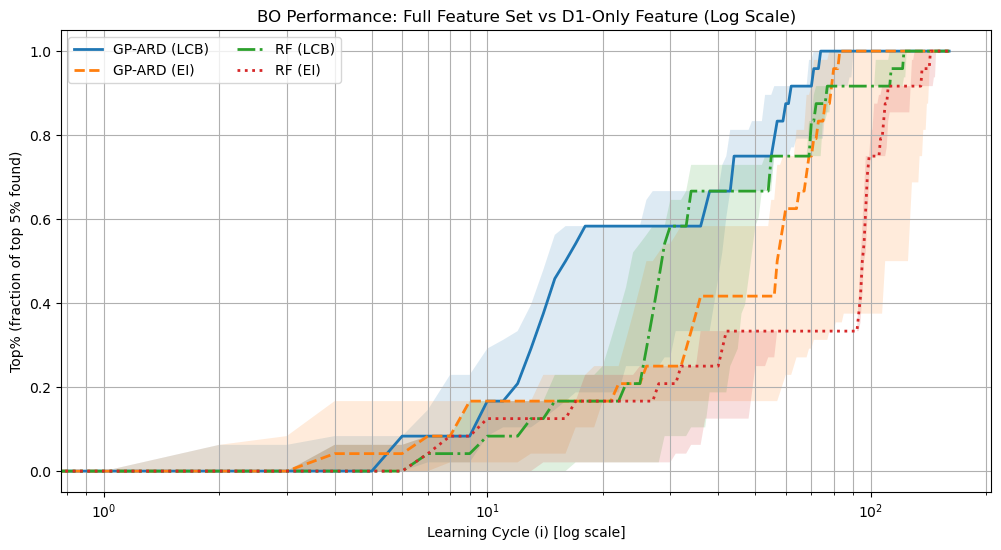

In [19]:
#Compare GP-ARD (LCB, EI) and RF (LCB, EI)
n_ensembles = 10
n_cycles = 160

results = {
    "GP-ARD (LCB)": [],
    "GP-ARD (EI)": [],
    "RF (LCB)": [],
    "RF (EI)": []
}

# Start clock for computation time 
start_time = time.perf_counter()

for s in range(n_ensembles):

    # ----- GP-ARD w/ LCB -----
    curve, _ = pool_based_bo(
        X, y,
        surrogate="gp",
        n_features=X.shape[1],
        n_init=2,
        n_cycles=n_cycles,
        seed=int(s),
        acquisition="lcb",
        acq_kwargs={"lam": 1.0}
    )
    if curve.shape[0] < n_cycles+1:
        curve = np.pad(curve, (0, n_cycles+1 - curve.shape[0]), constant_values=curve[-1])
    results["GP-ARD (LCB)"].append(curve)

    # ----- GP-ARD w/ EI -----
    curve, _ = pool_based_bo(
        X, y,
        surrogate="gp",
        n_features=X.shape[1],
        n_init=2,
        n_cycles=n_cycles,
        seed=int(s),
        acquisition="ei",
        acq_kwargs={"xi": 0.01}
    )
    if curve.shape[0] < n_cycles+1:
        curve = np.pad(curve, (0, n_cycles+1 - curve.shape[0]), constant_values=curve[-1])
    results["GP-ARD (EI)"].append(curve)

    # ----- RF w/ LCB -----
    curve, _ = pool_based_bo(
        X, y,
        surrogate="rf",
        n_features=X.shape[1],
        n_init=2,
        n_cycles=n_cycles,
        seed=int(s),
        acquisition="lcb",
        acq_kwargs={"lam": 1.0}
    )
    if curve.shape[0] < n_cycles+1:
        curve = np.pad(curve, (0, n_cycles+1 - curve.shape[0]), constant_values=curve[-1])
    results["RF (LCB)"].append(curve)

    # ----- RF w/ EI -----
    curve, _ = pool_based_bo(
        X, y,
        surrogate="rf",
        n_features=X.shape[1],
        n_init=2,
        n_cycles=n_cycles,
        seed=int(s),
        acquisition="ei",
        acq_kwargs={"xi": 0.01}
    )
    if curve.shape[0] < n_cycles+1:
        curve = np.pad(curve, (0, n_cycles+1 - curve.shape[0]), constant_values=curve[-1])
    results["RF (EI)"].append(curve)



# Convert lists -> arrays and compute stats
stats = {}
for key in results:
    arr = np.vstack(results[key])
    stats[key] = {
        "median": np.median(arr, axis=0),
        "p25":    np.percentile(arr, 25, axis=0),
        "p75":    np.percentile(arr, 75, axis=0)
    }

cycles = np.arange(n_cycles + 1)

# end clock 
end_time = time.perf_counter()
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time:.4f} seconds")

plt.figure(figsize=(12, 6))

styles = {
    "GP-ARD (LCB)": {"linestyle": "-",  "linewidth": 2},
    "GP-ARD (EI)":  {"linestyle": "--", "linewidth": 2},
    "RF (LCB)":     {"linestyle": "-.", "linewidth": 2},
    "RF (EI)":      {"linestyle": ":",  "linewidth": 2},
}

# Plot all 4 models
for key in stats:
    plt.plot(cycles, stats[key]["median"], label=key, **styles[key])
    plt.fill_between(cycles, stats[key]["p25"], stats[key]["p75"], alpha=0.15)

'''
plt.xlabel("Learning Cycle (i)")
plt.ylabel("Top% (Fraction of Top 5% Found)")
plt.title("Bayesian Optimization Comparison: GP-ARD vs RF (LCB & EI)")
plt.grid(True)
plt.legend()
plt.show()
'''

# Log scale 
plt.xscale("log")
plt.xlabel("Learning Cycle (i) [log scale]")
plt.ylabel("Top% (fraction of top 5% found)")
plt.title("BO Performance: Full Feature Set vs D1-Only Feature (Log Scale)")
plt.grid(True, which="both")
plt.legend(ncol=2)
plt.show()

# Aquisition Order 

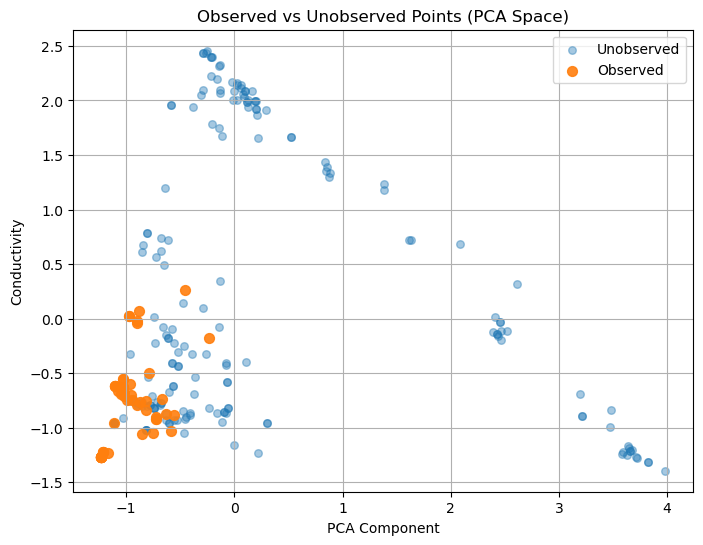

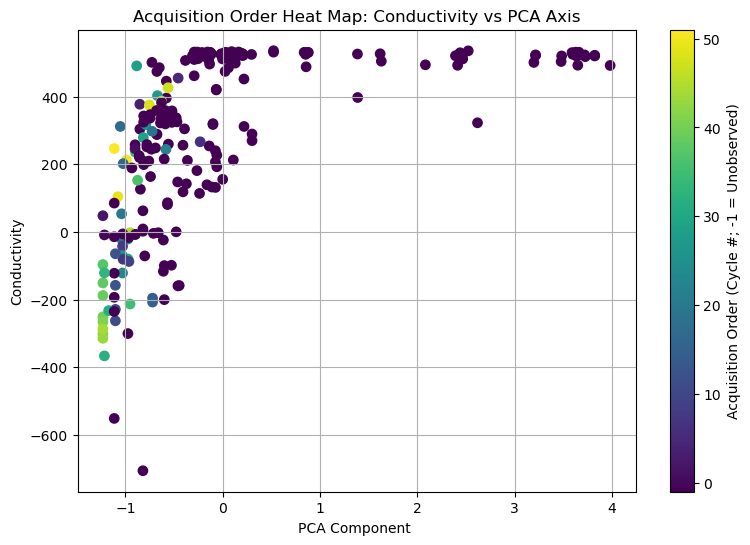

In [52]:
# Scatter plot of observed vs unobserved, plus heat map of acquisition order
# NOTE: Conductivity was negated -> lowest number = most conductive 

# Choose one surrogate/acquisition to visualize
curve_vis, observed_idx = pool_based_bo(
    X, y,
    surrogate="gp",
    n_features=X.shape[1],
    n_init=2,
    n_cycles=50,
    seed=0,
    acquisition="lcb",
    acq_kwargs={"lam": 1.0}
)

# Convert observed index list into an order lookup
acq_order = {idx: order for order, idx in enumerate(observed_idx)}

# Perform PCA 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Unscale original conductivity for plotting
y_original = y_scaler.inverse_transform(y.reshape(-1,1)).ravel()

# Scatter plot of Observed vs Unobserved
plt.figure(figsize=(8,6))

obs_mask = np.array([i in observed_idx for i in range(len(X_pca))])

plt.scatter(
    X_pca[~obs_mask, 0],
    X_pca[~obs_mask, 1],
    alpha=0.4,
    label="Unobserved",
    s=30
)

plt.scatter(
    X_pca[obs_mask, 0],
    X_pca[obs_mask, 1],
    alpha=0.9,
    label="Observed",
    s=50
)

plt.title("Observed vs Unobserved Points (PCA Space)")
plt.xlabel("PCA Component")
plt.ylabel("Conductivity")
plt.legend()
plt.grid(True)
plt.show()

# Heat map of acquisition order 
plt.figure(figsize=(9,6))

# Create an array assigning order to each point; unobserved = -1
order_array = np.array([acq_order.get(i, -1) for i in range(X.shape[0])])

scatter = plt.scatter(
    X_pca[:, 0],
    y_original,
    c=order_array,
    cmap="viridis",
    s=45
)

cbar = plt.colorbar(scatter)
cbar.set_label("Acquisition Order (Cycle #; -1 = Unobserved)")

plt.xlabel("PCA Component ")
plt.ylabel("Conductivity")
plt.title("Acquisition Order Heat Map: Conductivity vs PCA Axis")
plt.grid(True)
plt.show()

# Using D1 Content as a Baseline

In [53]:
# Runs BO for all 4 models (GP-LCB, GP-EI, RF-LCB, RF-EI) -> Returns a dictionary: model_name -> (median, p25, p75)
def run_bo_for_all_models(X, y, n_cycles=50, n_ensembles=10, seed_offset=0):
    results = {
        "GP-ARD (LCB)": [],
        "GP-ARD (EI)": [],
        "RF (LCB)": [],
        "RF (EI)": []
    }

    for s in range(n_ensembles):
        # ---- GP-ARD (LCB) ----
        curve, _ = pool_based_bo(
            X, y, surrogate="gp",
            n_features=X.shape[1],
            n_init=2, n_cycles=n_cycles,
            seed=seed_offset + s,
            acquisition="lcb",
            acq_kwargs={"lam": 1.0}
        )
        if curve.shape[0] < n_cycles + 1:
            curve = np.pad(curve, (0, n_cycles+1 - curve.shape[0]), constant_values=curve[-1])
        results["GP-ARD (LCB)"].append(curve)

        # ---- GP-ARD (EI) ----
        curve, _ = pool_based_bo(
            X, y, surrogate="gp",
            n_features=X.shape[1],
            n_init=2, n_cycles=n_cycles,
            seed=seed_offset + s,
            acquisition="ei",
            acq_kwargs={"xi": 0.01}
        )
        if curve.shape[0] < n_cycles+1:
            curve = np.pad(curve, (0, n_cycles+1 - curve.shape[0]), constant_values=curve[-1])
        results["GP-ARD (EI)"].append(curve)

        # ---- RF (LCB) ----
        curve, _ = pool_based_bo(
            X, y, surrogate="rf",
            n_features=X.shape[1],
            n_init=2, n_cycles=n_cycles,
            seed=seed_offset + s,
            acquisition="lcb",
            acq_kwargs={"lam": 1.0}
        )
        if curve.shape[0] < n_cycles+1:
            curve = np.pad(curve, (0, n_cycles+1 - curve.shape[0]), constant_values=curve[-1])
        results["RF (LCB)"].append(curve)

        # ---- RF (EI) ----
        curve, _ = pool_based_bo(
            X, y, surrogate="rf",
            n_features=X.shape[1],
            n_init=2, n_cycles=n_cycles,
            seed=seed_offset + s,
            acquisition="ei",
            acq_kwargs={"xi": 0.01}
        )
        if curve.shape[0] < n_cycles+1:
            curve = np.pad(curve, (0, n_cycles+1 - curve.shape[0]), constant_values=curve[-1])
        results["RF (EI)"].append(curve)

    # compute statistics
    stats = {}
    for key in results:
        arr = np.vstack(results[key])
        stats[key] = {
            "median": np.median(arr, axis=0),
            "p25": np.percentile(arr, 25, axis=0),
            "p75": np.percentile(arr, 75, axis=0)
        }

    return stats


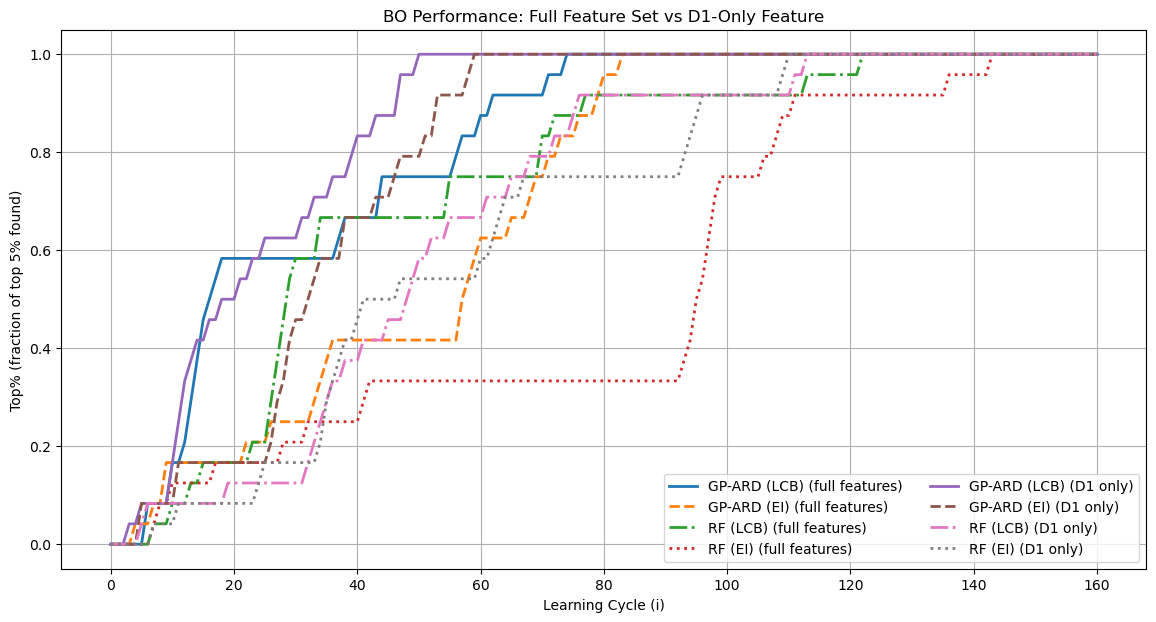

In [18]:
# Compare BO performance with full features vs D1-only feature

n_ensembles = 10
n_cycles = 160


# ---- FULL FEATURE RESULTS ----
stats_full = run_bo_for_all_models(X, y, n_cycles=n_cycles, n_ensembles=n_ensembles, seed_offset=0)

# ---- D1-ONLY FEATURE RESULTS ----
# Extract D1 column from the scaled X matrix
# find the original feature index first
d1_col_index = [i for i, name in enumerate(X_cols) if "D1" in name.upper()]
if len(d1_col_index) == 0:
    raise ValueError("Could not find a column containing 'D1' in X_cols.")
d1_col_index = d1_col_index[0]

X_d1 = X[:, [d1_col_index]]   # keep only 1 feature

stats_d1 = run_bo_for_all_models(X_d1, y, n_cycles=n_cycles, n_ensembles=n_ensembles, seed_offset=100)


# ---- PLOT RESULTS ----

cycles = np.arange(n_cycles + 1)

plt.figure(figsize=(14, 7))

styles_full = {
    "GP-ARD (LCB)": {"linestyle": "-",  "linewidth": 2},
    "GP-ARD (EI)":  {"linestyle": "--", "linewidth": 2},
    "RF (LCB)":     {"linestyle": "-.", "linewidth": 2},
    "RF (EI)":      {"linestyle": ":",  "linewidth": 2},
}

styles_d1 = {
    k: {**styles_full[k], "linewidth": 2}  # thinner line for D1-only
    for k in styles_full
}


# plot full-feature models
for key in stats_full:
    plt.plot(cycles, stats_full[key]["median"],
             label=f"{key} (full features)",
             **styles_full[key])
    #plt.fill_between(cycles, stats_full[key]["p25"], stats_full[key]["p75"], alpha=0.15)

# plot D1-only models
for key in stats_d1:
    plt.plot(cycles, stats_d1[key]["median"],
             label=f"{key} (D1 only)",
             **styles_d1[key])
    #plt.fill_between(cycles, stats_d1[key]["p25"], stats_d1[key]["p75"], alpha=0.10)

plt.xlabel("Learning Cycle (i)")
plt.ylabel("Top% (fraction of top 5% found)")
plt.title("BO Performance: Full Feature Set vs D1-Only Feature")
plt.grid(True)
plt.legend(ncol=2)
plt.show()

# ADD RANDOM BASELINE TO ANALYSIS

In [54]:
# ADD RANDOM BASLINE: 
def random_baseline(
    X, y,
    n_init=2,
    n_cycles=50,
    seed=None,
    top_fraction=0.05
):
    rng = np.random.RandomState(seed)
    N = X.shape[0]
    all_indices = np.arange(N)

    # Initial random observations
    observed_idx = rng.choice(all_indices, size=n_init, replace=False).tolist()
    remaining_idx = [i for i in all_indices if i not in observed_idx]

    # Top% metric
    topk = max(1, int(round(top_fraction * N)))
    top_indices = set(np.argsort(y)[:topk])

    top_found = [len(set(observed_idx) & top_indices) / topk]

    for _ in range(n_cycles):
        if not remaining_idx:
            break

        # random selection
        best_idx = rng.choice(remaining_idx)

        observed_idx.append(best_idx)
        remaining_idx.remove(best_idx)

        top_found.append(len(set(observed_idx) & top_indices) / topk)

    return np.array(top_found), observed_idx

# COMPARE ALL 4 MODELS w/ RANDOM BASELINE

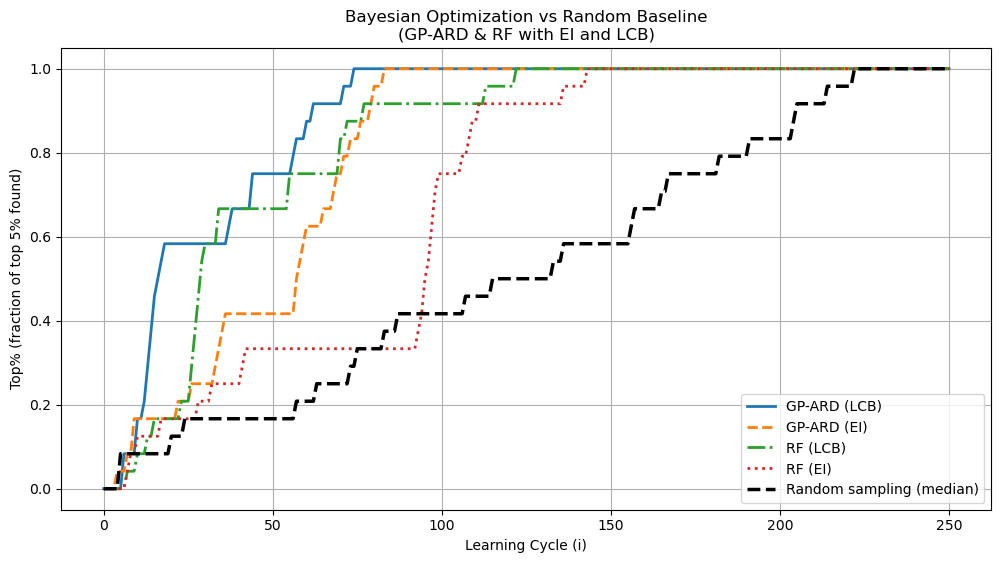

In [38]:
# Compare GP-ARD & RF (LCB/EI) with Random Baseline

n_ensembles = 10
n_cycles = 250
n_init = 2

results = {
    "GP-ARD (LCB)": [],
    "GP-ARD (EI)": [],
    "RF (LCB)": [],
    "RF (EI)": []
}

for s in range(n_ensembles):

    # ---- GP-ARD + LCB ----
    curve, _ = pool_based_bo(
        X, y, surrogate="gp",
        n_features=X.shape[1],
        n_init=n_init, n_cycles=n_cycles,
        seed=s,
        acquisition="lcb",
        acq_kwargs={"lam": 1.0}
    )
    curve = np.pad(curve, (0, n_cycles + 1 - len(curve)), constant_values=curve[-1])
    results["GP-ARD (LCB)"].append(curve)

    # ---- GP-ARD + EI ----
    curve, _ = pool_based_bo(
        X, y, surrogate="gp",
        n_features=X.shape[1],
        n_init=n_init, n_cycles=n_cycles,
        seed=s,
        acquisition="ei",
        acq_kwargs={"xi": 0.01}
    )
    curve = np.pad(curve, (0, n_cycles + 1 - len(curve)), constant_values=curve[-1])
    results["GP-ARD (EI)"].append(curve)

    # ---- RF + LCB ----
    curve, _ = pool_based_bo(
        X, y, surrogate="rf",
        n_features=X.shape[1],
        n_init=n_init, n_cycles=n_cycles,
        seed=s,
        acquisition="lcb",
        acq_kwargs={"lam": 1.0}
    )
    curve = np.pad(curve, (0, n_cycles + 1 - len(curve)), constant_values=curve[-1])
    results["RF (LCB)"].append(curve)

    # ---- RF + EI ----
    curve, _ = pool_based_bo(
        X, y, surrogate="rf",
        n_features=X.shape[1],
        n_init=n_init, n_cycles=n_cycles,
        seed=s,
        acquisition="ei",
        acq_kwargs={"xi": 0.01}
    )
    curve = np.pad(curve, (0, n_cycles + 1 - len(curve)), constant_values=curve[-1])
    results["RF (EI)"].append(curve)


# Compute statistics
stats = {}
for key in results:
    arr = np.vstack(results[key])
    stats[key] = {
        "median": np.median(arr, axis=0),
        "p25": np.percentile(arr, 25, axis=0),
        "p75": np.percentile(arr, 75, axis=0)
    }

# ---- Random baseline ----
random_curves = []

for s in range(n_ensembles):
    curve, _ = random_baseline(
        X, y,
        n_init=2,
        n_cycles=n_cycles,
        seed=s
    )
    curve = np.pad(curve, (0, n_cycles + 1 - len(curve)), constant_values=curve[-1])
    random_curves.append(curve)

random_curves = np.vstack(random_curves)

random_median = np.median(random_curves, axis=0)
random_p25 = np.percentile(random_curves, 25, axis=0)
random_p75 = np.percentile(random_curves, 75, axis=0)


cycles = np.arange(n_cycles + 1)

plt.figure(figsize=(12, 6))

styles = {
    "GP-ARD (LCB)": {"linestyle": "-",  "linewidth": 2},
    "GP-ARD (EI)":  {"linestyle": "--", "linewidth": 2},
    "RF (LCB)":     {"linestyle": "-.", "linewidth": 2},
    "RF (EI)":      {"linestyle": ":",  "linewidth": 2},
}

# Plot BO curves
for key in stats:
    plt.plot(cycles, stats[key]["median"], label=key, **styles[key])
    #plt.fill_between(cycles, stats[key]["p25"], stats[key]["p75"], alpha=0.15)

# Plot Random Baseline 
plt.plot( cycles, random_median, color="black", linestyle="--", linewidth=2.5, label="Random sampling (median)")
#plt.fill_between(cycles, random_p25, random_p75, color="gray", alpha=0.25, label="Random sampling (IQR)")

# Log x-axis
#plt.xscale("log")

plt.xlabel("Learning Cycle (i)")
plt.ylabel("Top% (fraction of top 5% found)")
plt.title("Bayesian Optimization vs Random Baseline\n(GP-ARD & RF with EI and LCB)")
plt.grid(True, which="both")
plt.legend()
plt.show()

# ENHANCEMENT FACTOR 

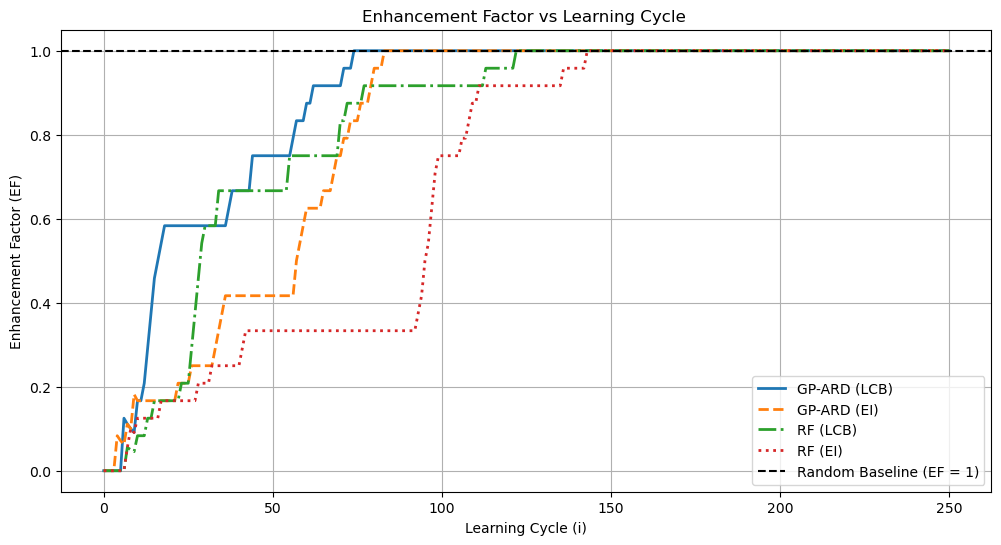

In [56]:
# Enhancement Factor - how much better 
# parameters
n_init = 2
n_cycles = 250
top_fraction = 0.05
N = X.shape[0]

# compute N_top
N_top = max(1, int(round(top_fraction * N)))
cycles = np.arange(n_cycles + 1)

# expected random baseline 
random_expected = np.minimum(n_init + cycles, N_top) / N_top

random_expected = np.minimum(random_expected, 1.0)

epsilon = 1e-12  # tiny floor to avoid numerical issues
random_safe = np.maximum(random_expected, epsilon)

# --- Enhancement Factor (EF) using random baseline ---
# NOT INVERTED
'''
ef_stats = {}
for key in stats:
    ef_median = stats[key]["median"] / random_safe
    ef_p25    = stats[key]["p25"] / random_safe
    ef_p75    = stats[key]["p75"] / random_safe
    ef_stats[key] = {"median": ef_median, "p25": ef_p25, "p75": ef_p75}
'''
# INVERTED 
ef_stats = {}
for key in stats:
    bo_safe = np.maximum(stats[key]["median"], epsilon)

    #ef_median = random_safe / bo_safe
    
    ef_median = bo_safe / random_safe
    #temp = bo_safe / random_safe
    #ef_median = 1/temp
    ef_p25 = random_safe / np.maximum(stats[key]["p75"], epsilon)
    ef_p75 = random_safe / np.maximum(stats[key]["p25"], epsilon)

    ef_stats[key] = {"median": ef_median, "p25": ef_p25, "p75": ef_p75}

plt.figure(figsize=(12,6))
styles = {
    "GP-ARD (LCB)": {"linestyle": "-",  "linewidth": 2},
    "GP-ARD (EI)" : {"linestyle": "--", "linewidth": 2},
    "RF (LCB)"    : {"linestyle": "-.", "linewidth": 2},
    "RF (EI)"     : {"linestyle": ":",  "linewidth": 2},
}

for key in ef_stats:
    plt.plot(cycles, ef_stats[key]["median"], label=f"{key}", **styles[key])
    #plt.fill_between(cycles, ef_stats[key]["p25"], ef_stats[key]["p75"], alpha=0.15)

plt.axhline(1.0, color="black", linestyle="--", linewidth=1.5, label="Random Baseline (EF = 1)")
#plt.xscale("log")
plt.xlabel("Learning Cycle (i)")
plt.ylabel("Enhancement Factor (EF)")
plt.title("Enhancement Factor vs Learning Cycle ")
plt.grid(True, which="both")
plt.legend()
plt.show()

# ACCELERATION FACTOR 

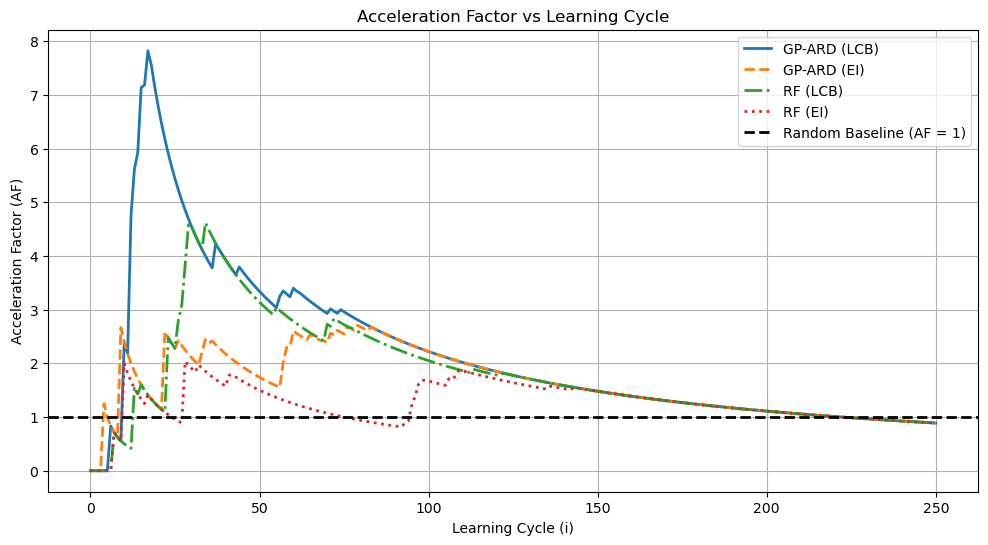

In [57]:
# Acceleration Factor - how much faster 
def compute_acceleration_factor(model_curve, random_curve):
    af = np.zeros_like(model_curve)

    for i, top_model in enumerate(model_curve):
        if i == 0 or top_model <= 0:
            af[i] = 0.0
            continue

        # Find earliest random cycle matching the same Top%
        j_candidates = np.where(random_curve >= top_model)[0]

        if len(j_candidates) == 0:
            af[i] = np.nan
        else:
            j_rand = j_candidates[0]
            af[i] = j_rand / i

    return af

af_stats = {}

for key in stats:
    af_stats[key] = compute_acceleration_factor(stats[key]["median"], random_median)
    
cycles = np.arange(n_cycles + 1)

plt.figure(figsize=(12, 6))

for key in af_stats:
    plt.plot(cycles, af_stats[key], label=key, **styles[key])

# Random baseline AF = 1
plt.axhline(
    y=1.0,
    color="black",
    linestyle="--",
    linewidth=2,
    label="Random Baseline (AF = 1)"
)

#plt.xscale("log")
plt.xlabel("Learning Cycle (i)")
plt.ylabel("Acceleration Factor (AF)")
plt.title("Acceleration Factor vs Learning Cycle")
plt.grid(True, which="both")
plt.legend()
plt.show()